<a href="https://colab.research.google.com/github/dcortese8/Sign-Language-Translator/blob/main/train_asl_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/dcortese8/Sign-Language-Translator.git
%cd Sign-Language-Translator/train

Cloning into 'Sign-Language-Translator'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 251 (delta 41), reused 50 (delta 17), pack-reused 172
Receiving objects: 100% (251/251), 97.50 MiB | 18.04 MiB/s, done.
Resolving deltas: 100% (96/96), done.
/content/Sign-Language-Translator/train


In [2]:
from zipfile import ZipFile
from google.colab import drive

drive.mount('/content/gdrive')

file_name = '/content/gdrive/MyDrive/videos.zip'

with ZipFile(file_name, 'r') as zipfile:
  zipfile.extractall()
  print('Done')

Mounted at /content/gdrive
Done


In [3]:
!pip install tensorflow
!pip install tf-models-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 13.1 MB/s 
     |████████████████████████████████| 352 kB 70.6 MB/s 
     |████████████████████████████████| 5.8 MB 58.6 MB/s 
     |████████████████████████████████| 662 kB 69.4 MB/s 
     |████████████████████████████████| 118 kB 74.1 MB/s 
     |████████████████████████████████| 1.1 MB 70.6 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 588.3 MB 26 kB/s 
     |████████████████████████████████| 1.3 MB 83.0 MB/s 
     |████████████████████████████████| 238 kB 79.1 MB/s 
     |████████████████████████████████| 6.0 MB 35.5 MB/s 
     |████████████████████████████████| 439 kB 76.5 MB/s 
     |████████████████████████████████| 1.7 MB 39.4 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.

In [4]:
import json
import pandas as pd
import os
import shutil

import numpy as np
import pathlib
import os
import random
import datetime
from FrameGenerator import FrameGenerator
import cv2
import tensorflow as tf
import tensorflow_hub as hub
from CustomMovinet import CustomModel
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model
from PlotLearning import *

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [6]:
def get_metadata(file):
    
    """ Creates dataframe from the json file containing video info and labels.
    
        Args:
            file: filename and path to the json.

        Return:
            A formatted pandas dataframe of the json file.
    """
    
    # read and load json file from specified path
    with open(file, 'r') as data_file:
        instance_json = json.load(data_file)

    # convert json format to readable pandas df
    metadata = pd.DataFrame()
    for i in range(0, len(instance_json)):

        label_ins = instance_json[i]
        gloss = label_ins['gloss']

        for i in range(0, len(label_ins['instances'])):

            label_ins['instances'][i]['gloss'] = gloss
            frame = pd.Series(label_ins['instances'][i]).to_frame().T
            metadata = pd.concat([metadata, frame])

    return metadata



def create_gloss_variations(df):
    # combine gloss and variation id columns
    df['gloss'] = df['gloss'] + df['variation_id'].astype(str)
    return df



def convert_sample_type(df, og_split = 'test', tgt_split = 'train'):
    # reassign test samples to train
    df['split'] = df['split'].replace({og_split: tgt_split})
    return df


def videos_to_folders(df, to_folder='data', type='copy', prototype=True):

    if prototype:
        df = df[df['gloss'].isin(['hello0', 'love0', 'thank you0'])]

    paths = df[['split', 'gloss']].drop_duplicates()#.apply(lambda row: os.path.join(*row), axis=1)
    for s, g in zip(paths['split'], paths['gloss']):
        move_to = os.path.join(to_folder, s, g)
        if not os.path.exists(move_to):
            os.makedirs(move_to)

        vid_ids = df[(df['split'] == s) & (df['gloss'] == g)]['video_id']
        for id in vid_ids:
            vid = os.path.join('videos', str(id)) + '.mp4'
            if os.path.exists(vid):
                if type == 'move':
                    move = shutil.move(vid, move_to)
                elif type == 'copy':
                    move = shutil.copy(vid, move_to)
                else:
                    raise Exception("Arg 'type' must be set to 'move or 'copy'")      
            else:
                print("Video file missing: ", vid)


In [7]:
file = 'labels/WLASL_v0.3.json'
print('Getting metadata....')
metadata = get_metadata(file)
print('Creating gloss variations....')
gloss_variations = create_gloss_variations(metadata)
print('Converting sample types....')
sample_type = convert_sample_type(gloss_variations)
print('Moving videos to folders....')
to_folders = videos_to_folders(sample_type, type='move', prototype=True)


Getting metadata....
Creating gloss variations....
Converting sample types....
Moving videos to folders....


In [10]:
data_path='data'
num_frames=8
model_id='a0'
batches = 8

In [53]:
#actions = np.array(['hello', 'love', 'thank you'])
#splits = metadata['split'].unique()

if not os.path.exists(data_path):
    raise Exception('Data path does not exist. Run preprocess.py')

subset_paths = {
    'train': pathlib.Path(os.path.join(data_path, 'train')),
    'val': pathlib.Path(os.path.join(data_path, 'val'))
}

num_classes = len(next(os.walk(subset_paths['train']))[1])

output_signature = (
    tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
    tf.TensorSpec(shape = (None,), dtype = tf.uint8)
)

train_ds = tf.data.Dataset.from_generator(
    FrameGenerator(subset_paths['train'], num_frames),
    output_signature = output_signature
)

# Create the validation set
val_ds = tf.data.Dataset.from_generator(
    FrameGenerator(subset_paths['val'], num_frames),
    output_signature = output_signature
)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

train_ds = train_ds.batch(batches)
val_ds = val_ds.batch(batches)

train_ds_len = len(list(subset_paths["train"].glob('*/*.mp4')))
val_ds_len = len(list(subset_paths["val"].glob('*/*.mp4')))

In [54]:
# Create backbone and model
use_positional_encoding = model_id in {'a3', 'a4', 'a5'}
backbone = movinet.Movinet(
    model_id=model_id,
    causal=True,
    conv_type='2plus1d',
    se_type='2plus3d',
    activation='hard_swish',
    gating_activation='hard_sigmoid',
    use_positional_encoding=use_positional_encoding,
    use_external_states=False
)

# # Create a movinet classifier using this backbone.
# model = movinet_model.MovinetClassifier(
# 	backbone,
# 	num_classes=600,
# 	output_states=True)

model = movinet_model.MovinetClassifier(
    backbone=backbone,
    num_classes=3,
    output_states=True
)


In [55]:
#movinet_hub_url = f'https://tfhub.dev/tensorflow/movinet/{model_id}/stream/kinetics-600/classification/3'
movinet_hub_path = f'movinet_a0_stream_kinetics-600_classification_3'

movinet_hub_model = hub.KerasLayer(movinet_hub_path, trainable=True)

In [61]:
# Input layer for the frame sequence
image_input = tf.keras.layers.Input(
    shape=[None, None, None, 3],
    dtype=tf.float32,
    name='image'
)

# Input layers for the different model states.
init_states_fn = movinet_hub_model.resolved_object.signatures['init_states']

state_shapes = {
    name: ([s if s > 0 else None for s in state.shape], state.dtype)
    for name, state in init_states_fn(tf.constant([0, 0, 0, 0, 3])).items()
}

states_input = {
    name: tf.keras.Input(shape[1:], dtype=dtype, name=name)
    for name, (shape, dtype) in state_shapes.items()
}

# Wrap the Movinet model in a Keras model so that it can be finetuned.

inputs = {**states_input, 'image': image_input}

outputs = model(inputs)

model = CustomModel(inputs, outputs, name='movinet')

for layer in model.layers[:-1]:
    layer.trainable = False
model.layers[-1].trainable = True

init_states = init_states_fn(tf.shape(tf.ones([batches, num_frames, 172, 172, 3])))



def add_states(video, label, stream_states=init_states):
    return ({**stream_states, "image": video} , label)



train = train_ds.map(add_states)
val = val_ds.map(add_states)

num_epochs = 1000

train_steps = train_ds_len // batches
total_train_steps = train_steps * num_epochs
test_steps = (val_ds_len // batches) or 1

loss_obj = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
    label_smoothing=0.1
)

metrics = [
    tf.keras.metrics.TopKCategoricalAccuracy(
        k=1, name='top_1', dtype=tf.float32
        ),
    tf.keras.metrics.TopKCategoricalAccuracy(
        k=3, name='top_3', dtype=tf.float32
        ),
]

initial_learning_rate = 0.01
learning_rate = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=total_train_steps,
)

optimizer = tf.keras.optimizers.RMSprop(
    learning_rate, rho=0.9, momentum=0.9, epsilon=1.0, clipnorm=1.0)

#model.compile(loss=loss_obj, optimizer=tf.keras.optimizers.Adam(), metrics=metrics)
model.compile(loss=loss_obj, optimizer=optimizer, metrics=metrics)

checkpoint_filepath = "train/movinet_checkpoints_stream"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_top_3',
    mode='max',
    save_best_only=True
)

logdir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard --logdir=./notebooks/logs

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=logdir),
    #model_checkpoint_callback,
    #tf.keras.callbacks.EarlyStopping(monitor='val_top_3', patience=50),
    PlotLearning()
]


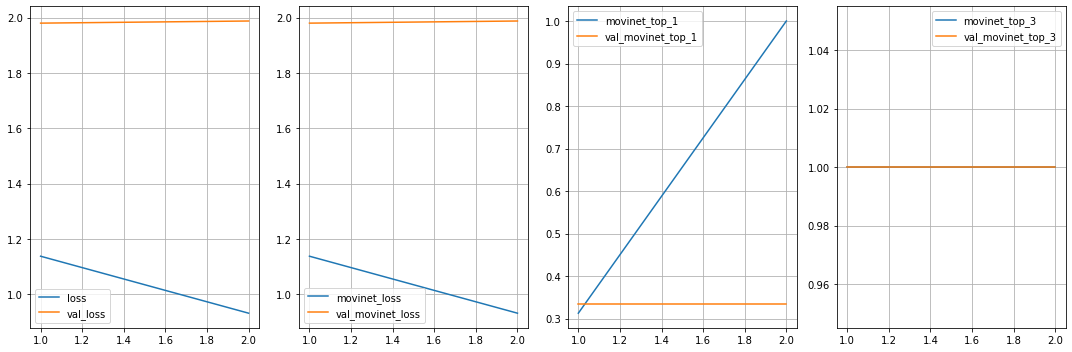

4/4 [==============================] - 2s 367ms/step - loss: 0.9311 - movinet_loss: 0.9311 - movinet_top_1: 1.0000 - movinet_top_3: 1.0000 - val_loss: 1.9878 - val_movinet_loss: 1.9878 - val_movinet_top_1: 0.3333 - val_movinet_top_3: 1.0000


In [62]:
#train_dataset = train
#valid_dataset = val

#print("Beginning fit....")
with tf.device('/CPU:0'):
    #results = model_wrapped.fit(
    results = model.fit(
    #results = model_movinet.fit(
        train,
        validation_data=val,
        epochs=num_epochs,
        steps_per_epoch=train_steps,
        validation_steps=test_steps,
        callbacks=callbacks,
        validation_freq=1,
        verbose=1
    )


In [15]:
model.save('models/movinet_aslt_prototype')

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['state/b2/l1/stream_buffer', 'state/b3/l1/pool_buffer', 'state/b4/l1/pool_frame_count', 'state/b2/l0/pool_frame_count', 'state/b1/l2/pool_frame_count', 'state/b4/l0/pool_frame_count', 'state/b4/l2/pool_frame_count', 'state/b2/l0/pool_buffer', 'state/b2/l0/stream_buffer', 'state/b3/l2/pool_frame_count', 'state/b1/l2/pool_buffer', 'state/b3/l3/pool_buffer', 'state/b4/l0/pool_buffer', 'state/b4/l2/pool_buffer', 'state/b3/l0/pool_buffer', 'state/b3/l1/stream_buffer', 'state/b1/l0/pool_buffer', 'state/b3/l0/pool_frame_count', 'state/b1/l1/pool_frame_count', 'state/b3/l2/stream_buffer', 'state/b1/l0/pool_frame_count', 'state/b1/l0/stream_buffer', 'state/head/pool_buffer', 'state/b3/l3/pool_frame_count', 'state/b3/l1/pool_frame_count', 'state/b2/l1/pool_frame_count', 'state/b3/l0/stream_buffer', 'state/b3/l2/pool_buffer', 'state/b4/l3/pool_frame_count', 'state/b4/l3/pool_buffer', 'st